# Bearing Health Monitoring 
Data from the NSF I/UCR Center for Intelligent Maintenance Systems (IMS – www.imscenter.net) with support from Rexnord Corp. in Milwaukee, WI. 

http://data-acoustics.com/measurements/bearing-faults/bearing-4/

By: Michael Mehallow

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt

In [2]:
from scipy import stats
from sklearn.metrics import mean_squared_error
import libarchive

In [3]:
folder = 'C:/Users/Michael/Documents/Data-Science/Bearing-Anomaly-Detection/1st_test_extract/'

## Read data

In [4]:
df = pd.read_csv(folder + '2003.10.22.12.06.24',
           sep='\t',
           header=None,
           names=['Bearing 1 Ch1', 'Bearing 1 Ch2',
                  'Bearing 2 Ch1', 'Bearing 2 Ch2',
                  'Bearing 3 Ch1', 'Bearing 3 Ch2',
                  'Bearing 4 Ch1', 'Bearing 4 Ch2'])

Define function to be used later to read multiple files.

In [5]:
def read_vibration_file(filename):
    df = pd.read_csv(folder + filename,
           sep='\t',
           header=None,
           names=['Bearing 1 Ch1', 'Bearing 1 Ch2',
                  'Bearing 2 Ch1', 'Bearing 2 Ch2',
                  'Bearing 3 Ch1', 'Bearing 3 Ch2',
                  'Bearing 4 Ch1', 'Bearing 4 Ch2'])
    return df

In [6]:
df.head()

,Bearing 1 Ch1,Bearing 1 Ch2,Bearing 2 Ch1,Bearing 2 Ch2,Bearing 3 Ch1,Bearing 3 Ch2,Bearing 4 Ch1,Bearing 4 Ch2
0,-0.022,-0.039,-0.183,-0.054,-0.105,-0.134,-0.129,-0.142
1,-0.105,-0.017,-0.164,-0.183,-0.049,0.029,-0.115,-0.122
2,-0.183,-0.098,-0.195,-0.125,-0.005,-0.007,-0.171,-0.071
3,-0.178,-0.161,-0.159,-0.178,-0.100,-0.115,-0.112,-0.078
4,-0.208,-0.129,-0.261,-0.098,-0.151,-0.205,-0.063,-0.066


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20480 entries, 0 to 20479
Data columns (total 8 columns):
Bearing 1 Ch1    20480 non-null float64
Bearing 1 Ch2    20480 non-null float64
Bearing 2 Ch1    20480 non-null float64
Bearing 2 Ch2    20480 non-null float64
Bearing 3 Ch1    20480 non-null float64
Bearing 3 Ch2    20480 non-null float64
Bearing 4 Ch1    20480 non-null float64
Bearing 4 Ch2    20480 non-null float64
dtypes: float64(8)
memory usage: 1.3 MB


Visualize the time-series sensor data for one file

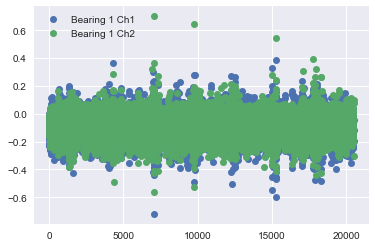

In [8]:
df[['Bearing 1 Ch1', 'Bearing 1 Ch2']].plot(marker='o', linewidth=0)

## Aggregate metrics by sample
I will choose to use the root mean square as a metric of the vibrational intensity during the time-series sample.

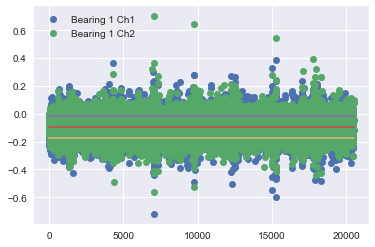

In [13]:
# Plot time series data again for one sample
df[['Bearing 1 Ch1', 'Bearing 1 Ch2']].plot(marker='o', linewidth=0)

# Calculate mean of each channel for Bearing 1
ch1_mean = df['Bearing 1 Ch1'].mean()
ch2_mean = df['Bearing 1 Ch2'].mean()

# Calculate the root mean square variation (RMS) for each channel
ch1_rms = np.sqrt(sum(df['Bearing 1 Ch1'].apply(lambda x: (x - ch1_mean)**2))/len(df))
ch2_rms = np.sqrt(sum(df['Bearing 1 Ch2'].apply(lambda x: (x - ch2_mean)**2))/len(df))

# Overlay mean and RMS bands
plt.plot([0, len(df)], [ch1_mean, ch1_mean])
plt.plot([0, len(df)], [ch1_mean+ch1_rms, ch1_mean+ch1_rms])
plt.plot([0, len(df)], [ch1_mean-ch1_rms, ch1_mean-ch1_rms])

In [14]:
def calculate_rms(series):
    series_mean = series.mean()

    series_rms = np.sqrt(sum(series.apply(lambda x: (x - series_mean)**2))/len(series)) 
    
    return series_rms

## Calculate RMS levels for every sample file

In [15]:
print('Number of sample files : ' + str(len(os.listdir(folder))))

Number of sample files : 2156


Create a dictionary of RMS values

In [ ]:
rms_dict = {}
for filename in os.listdir(folder):
    df = read_vibration_file(filename)
    rms_dict[filename] = [calculate_rms(df[column]) for column in df.columns]

Convert dictionary to dataframe

In [ ]:
rms = pd.DataFrame.from_dict(rms_dict,
                       orient='index',
                       columns=df.columns)

Save dataframe for future use

In [ ]:
rms.to_csv('C:/Users/Michael/Documents/Data-Science/Bearing-Anomaly-Detection/rms.csv')

Read dataframe from csv file

In [160]:
rms = pd.read_csv('C:/Users/Michael/Documents/Data-Science/Bearing-Anomaly-Detection/rms.csv')

# Rename datetime column
rms = rms.rename(columns={'Unnamed: 0' : 'Sample Datetime'})

# Convert datetime format
rms['Sample Datetime'] = pd.to_datetime(rms['Sample Datetime'], format='%Y.%m.%d.%H.%M.%S')

rms = rms.set_index('Sample Datetime')

In [161]:
rms.head()

,Bearing 1 Ch1,Bearing 1 Ch2,Bearing 2 Ch1,Bearing 2 Ch2,Bearing 3 Ch1,Bearing 3 Ch2,Bearing 4 Ch1,Bearing 4 Ch2
Sample Datetime,,,,,,,,
2003-10-22 12:06:24,0.081122,0.070648,0.090648,0.077508,0.091461,0.095486,0.060085,0.066380
2003-10-22 12:09:13,0.079515,0.069529,0.090258,0.076739,0.091732,0.094383,0.059420,0.064744
2003-10-22 12:14:13,0.080217,0.069464,0.090234,0.077096,0.091813,0.094055,0.059968,0.065253
2003-10-22 12:19:13,0.080825,0.071265,0.090272,0.076528,0.092385,0.096505,0.059915,0.066301
2003-10-22 12:24:13,0.082034,0.072153,0.088861,0.076045,0.091932,0.095043,0.059255,0.066279


Visualize time series samples of RMS for each bearing and channel

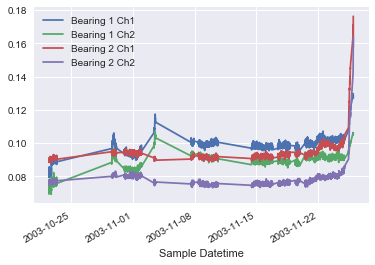

In [166]:
rms[['Bearing 1 Ch1', 'Bearing 1 Ch2', 'Bearing 2 Ch1', 'Bearing 2 Ch2']].plot()

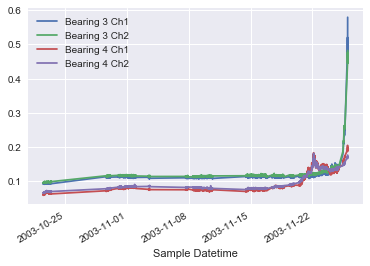

In [167]:
rms[['Bearing 3 Ch1', 'Bearing 3 Ch2', 'Bearing 4 Ch1', 'Bearing 4 Ch2']].plot()

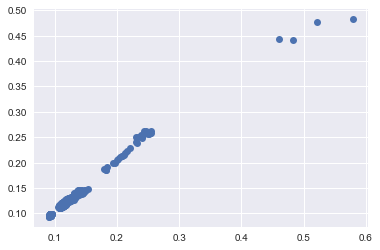

In [168]:
plt.plot(rms['Bearing 3 Ch1'], rms['Bearing 3 Ch2'],'o')

Plot data excluding outliers (from when bearings had deteriorated)

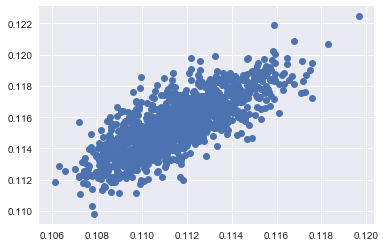

In [169]:
plt.plot(rms.iloc[157:-700]['Bearing 3 Ch1'], rms.iloc[157:-700]['Bearing 3 Ch2'],'o')

## Find Principal Components using PCA


In [170]:
from sklearn.decomposition import PCA

In [171]:
rms.head()

,Bearing 1 Ch1,Bearing 1 Ch2,Bearing 2 Ch1,Bearing 2 Ch2,Bearing 3 Ch1,Bearing 3 Ch2,Bearing 4 Ch1,Bearing 4 Ch2
Sample Datetime,,,,,,,,
2003-10-22 12:06:24,0.081122,0.070648,0.090648,0.077508,0.091461,0.095486,0.060085,0.066380
2003-10-22 12:09:13,0.079515,0.069529,0.090258,0.076739,0.091732,0.094383,0.059420,0.064744
2003-10-22 12:14:13,0.080217,0.069464,0.090234,0.077096,0.091813,0.094055,0.059968,0.065253
2003-10-22 12:19:13,0.080825,0.071265,0.090272,0.076528,0.092385,0.096505,0.059915,0.066301
2003-10-22 12:24:13,0.082034,0.072153,0.088861,0.076045,0.091932,0.095043,0.059255,0.066279


In [172]:
# Select healthy data as training
train = rms[0:-700][['Bearing 3 Ch1', 'Bearing 3 Ch2']].copy()

# Select data and fit PCA model
pca_model = PCA(n_components=2)
pca_model.fit(train[['Bearing 3 Ch1', 'Bearing 3 Ch2']].values)

# Tranform data into new principal component axis
train['Bearing 3 PC1'], train['Bearing 3 PC2'] = zip(*pca_model.transform(train[['Bearing 3 Ch1', 'Bearing 3 Ch2']].values))

# Find guassian distribution parameters
model = train.agg({'Bearing 3 Ch1': ['mean', 'std'],
                'Bearing 3 Ch2': ['mean', 'std'],
                'Bearing 3 PC1': ['mean', 'std'],
                'Bearing 3 PC2': ['mean', 'std']})

# Find p values for all channels
for ch in train.columns:
    train[ch + ' z'] = (train[ch] - model[ch]['mean'])/model[ch]['std']
    
    train[ch + ' p'] = stats.norm.sf(abs(train[ch + ' z']))*2
    

# Calculate multivariate p value of data (assuming variation is axis-aligned)
train['Ch_p_value'] = train['Bearing 3 Ch1 p']*train['Bearing 3 Ch2 p']

# Calculate multivariate p value of principal components
train['PC_p_value'] = train['Bearing 3 PC1 p']*train['Bearing 3 PC2 p']   

In [173]:
train.head()

,Bearing 3 Ch1,Bearing 3 Ch2,Bearing 3 PC1,Bearing 3 PC2,Bearing 3 Ch1 z,Bearing 3 Ch1 p,Bearing 3 Ch2 z,Bearing 3 Ch2 p,Bearing 3 PC1 z,Bearing 3 PC1 p,Bearing 3 PC2 z,Bearing 3 PC2 p,Ch_p_value,PC_p_value
Sample Datetime,,,,,,,,,,,,,,
2003-10-22 12:06:24,0.091461,0.095486,0.025495,0.000062,-2.975835,0.002922,-2.961757,0.003059,2.985760,0.002829,0.067435,0.946236,0.000009,0.002677
2003-10-22 12:09:13,0.091732,0.094383,0.026084,-0.000908,-2.931059,0.003378,-3.142898,0.001673,3.054819,0.002252,-0.992757,0.320828,0.000006,0.000722
2003-10-22 12:14:13,0.091813,0.094055,0.026260,-0.001197,-2.917735,0.003526,-3.196874,0.001389,3.075405,0.002102,-1.308581,0.190676,0.000005,0.000401
2003-10-22 12:19:13,0.092385,0.096505,0.024120,0.000126,-2.823300,0.004753,-2.794228,0.005202,2.824780,0.004731,0.137725,0.890458,0.000025,0.004213
2003-10-22 12:24:13,0.091932,0.095043,0.025476,-0.000584,-2.898135,0.003754,-3.034548,0.002409,2.983615,0.002849,-0.638816,0.522943,0.000009,0.001490


## Visualize P values using distributions
The following two plots show that using a multivariate p value on regular gaussian modelled data, and on the principal components. Calculating the p values based on the principal components better represents the data as it adapts to the difference in variation in the directions. 

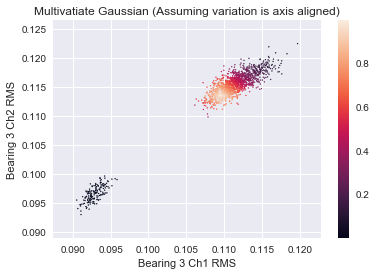

In [174]:
plt.scatter(train['Bearing 3 Ch1'], train['Bearing 3 Ch2'], [], train['Ch_p_value'])
plt.colorbar()
plt.title('Multivatiate Gaussian (Assuming variation is axis aligned)')
plt.xlabel('Bearing 3 Ch1 RMS')
plt.ylabel('Bearing 3 Ch2 RMS')
plt.show()

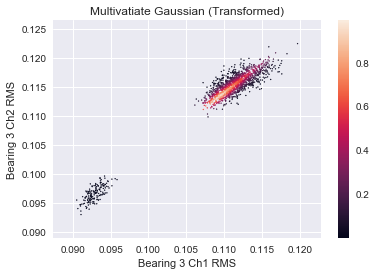

In [175]:
plt.scatter(train['Bearing 3 Ch1'], train['Bearing 3 Ch2'], [], train['PC_p_value'])
plt.colorbar()
plt.xlabel('Bearing 3 Ch1 RMS')
plt.ylabel('Bearing 3 Ch2 RMS')
plt.title('Multivatiate Gaussian (Transformed)')
plt.show()

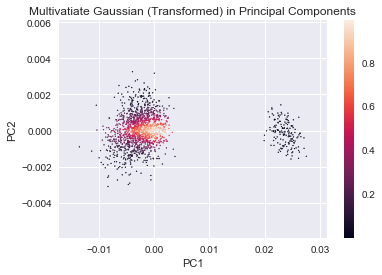

In [176]:
plt.scatter(train['Bearing 3 PC1'], train['Bearing 3 PC2'], [], train['PC_p_value'])
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Multivatiate Gaussian (Transformed) in Principal Components')
plt.show()

## Apply model to all data

In [177]:
# Tranform data into new principal component axis
rms['Bearing 3 PC1'], rms['Bearing 3 PC2'] = zip(*pca_model.transform(rms[['Bearing 3 Ch1', 'Bearing 3 Ch2']].values))

# Find p values for all channels
for ch in ['Bearing 3 PC1', 'Bearing 3 PC2']:
    rms[ch + ' z'] = (rms[ch] - model[ch]['mean'])/model[ch]['std']
    
    rms[ch + ' p'] = stats.norm.sf(abs(rms[ch + ' z']))*2
    
# Calculate multivariate p value of principal components
rms['PC_p_value'] = rms['Bearing 3 PC1 p']*rms['Bearing 3 PC2 p']   

In [178]:
rms.head()

,Bearing 1 Ch1,Bearing 1 Ch2,Bearing 2 Ch1,Bearing 2 Ch2,Bearing 3 Ch1,Bearing 3 Ch2,Bearing 4 Ch1,Bearing 4 Ch2,Bearing 3 PC1,Bearing 3 PC2,Bearing 3 PC1 z,Bearing 3 PC1 p,Bearing 3 PC2 z,Bearing 3 PC2 p,PC_p_value
Sample Datetime,,,,,,,,,,,,,,,
2003-10-22 12:06:24,0.081122,0.070648,0.090648,0.077508,0.091461,0.095486,0.060085,0.066380,0.025495,0.000062,2.985760,0.002829,0.067435,0.946236,0.002677
2003-10-22 12:09:13,0.079515,0.069529,0.090258,0.076739,0.091732,0.094383,0.059420,0.064744,0.026084,-0.000908,3.054819,0.002252,-0.992757,0.320828,0.000722
2003-10-22 12:14:13,0.080217,0.069464,0.090234,0.077096,0.091813,0.094055,0.059968,0.065253,0.026260,-0.001197,3.075405,0.002102,-1.308581,0.190676,0.000401
2003-10-22 12:19:13,0.080825,0.071265,0.090272,0.076528,0.092385,0.096505,0.059915,0.066301,0.024120,0.000126,2.824780,0.004731,0.137725,0.890458,0.004213
2003-10-22 12:24:13,0.082034,0.072153,0.088861,0.076045,0.091932,0.095043,0.059255,0.066279,0.025476,-0.000584,2.983615,0.002849,-0.638816,0.522943,0.001490


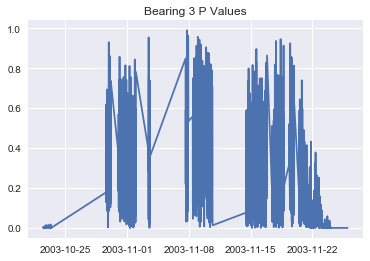

In [179]:
plt.plot(rms['PC_p_value'])
plt.title('Bearing 3 P Values')
plt.show()

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


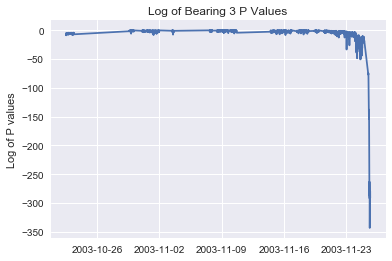

In [180]:
plt.plot(np.log(rms['PC_p_value']))
plt.ylabel('Log of P values')
plt.title('Log of Bearing 3 P Values')
plt.show()

## Detection
Detect an anomaly if the vibrations exceed a p value lower than 0.0001

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


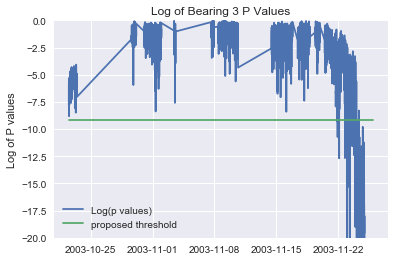

In [183]:
plt.plot(np.log(rms['PC_p_value']))
plt.plot([min(rms.index), max(rms.index)], [np.log(1e-4), np.log(1e-4)])
plt.ylabel('Log of P values')
plt.title('Log of Bearing 3 P Values')
plt.ylim([-20, 0])
plt.legend(['Log(p values)', 'proposed threshold'])
plt.show()

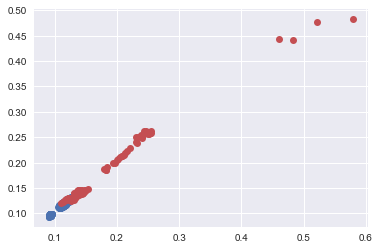

In [184]:
anomaly = rms['PC_p_value']<1e-4

plt.plot(rms[~anomaly]['Bearing 3 Ch1'], rms[~anomaly]['Bearing 3 Ch2'], 'o')
plt.plot(rms[anomaly]['Bearing 3 Ch1'], rms[anomaly]['Bearing 3 Ch2'], 'ro')

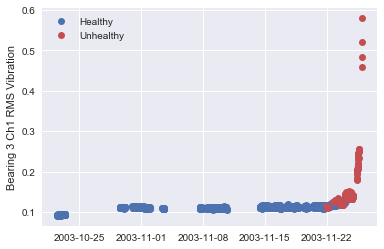

In [185]:
anomaly = rms['PC_p_value']<1e-4

plt.plot(rms[~anomaly]['Bearing 3 Ch1'], 'o')
plt.plot(rms[anomaly]['Bearing 3 Ch1'], 'ro')
plt.ylabel('Bearing 3 Ch1 RMS Vibration')
plt.legend(['Healthy', 'Unhealthy'])
plt.show()

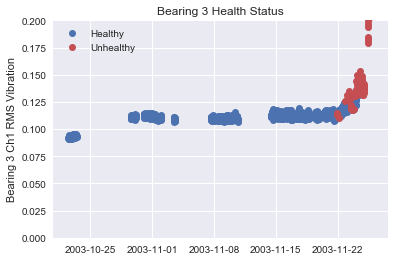

In [186]:
anomaly = rms['PC_p_value']<1e-4

plt.plot(rms[~anomaly]['Bearing 3 Ch1'], 'o')
plt.plot(rms[anomaly]['Bearing 3 Ch1'], 'ro')
plt.ylabel('Bearing 3 Ch1 RMS Vibration')
plt.legend(['Healthy', 'Unhealthy'])
plt.ylim([0, 0.2])
plt.title('Bearing 3 Health Status')
plt.show()

In [193]:
first_anomaly_time = min(rms[~anomaly].index)
final_run_time = max(rms.index)

predictive_time = final_run_time - first_anomaly_time

In [194]:
print('Bearing 3 Predictive Time : ' + str(predictive_time))

Bearing 3 Predictive Time : 34 days 11:33:32
